# t-SNE visualization for the lyh-dataset

## Brief introduction to t-SNE

t-SNE or T-distributed stochastic neighbour embedding takes a high dimensional dataset and reduces it to a low dimensional graph that retains a lot fo the original infomation. It does so by giving each data point a location in a two or three-dimensional map. This technique finds clusters in data thereby making sure that an embedding preserves the meaning in the data. t-SNE reduces dimensionality while trying to keep similar instances close and dissimilar instances apart.

> The difference between t-SNE and PCA
> 
> PCA is a **linear projection**, which means it can't capture non-linear dependencies. 

## Step 1. Prepare the data

In [1]:
# imports
from scipy.io import loadmat
import numpy as np
import os

In [2]:
# switch the os.path to the parent dir
current_path = os.getcwd()
parent_path = os.path.dirname(current_path)

os.chdir(parent_path)

In [3]:
def load_lyh_data(sessionId, train_idx=10):
    '''
    parse the lyh dataset original data

    Parameters
    ----------
    - sessionId: str
        exlusively ("v2", "v3", "v4"), which denotes the proper one that will be loaded.
    - train_idx: int 
        for splitting train/test set, defaults to 30

    Return
    ------
    - data:
        - 'data': np.ndarray
            (n_trials, n_chans, n_times)
        - 'label': np.ndarray
            (n_trials,)
    '''
    # X_tot = []
    # y_tot = []

    dir_path = "data"
    left_v2_fp = "left_processed_v2(300).npy"
    left_v3_fp = "left_processed_v3(500).npy"
    left_v4_fp = "left_processed_v4(500).npy"
    right_v2_fp = "right_processed_v2(300).npy"
    right_v3_fp = "right_processed_v3(500).npy"
    right_v4_fp = "right_processed_v4(500).npy"
    leg_v2_fp = "leg_processed_v2(300).npy"
    leg_v3_fp = "leg_processed_v3(500).npy"
    leg_v4_fp = "leg_processed_v4(500).npy"
    nothing_v2_fp = "nothing_processed_v2(300).npy"
    nothing_v3_fp = "nothing_processed_v3(500).npy"
    nothing_v4_fp = "nothing_processed_v4(500).npy"
    
    # get all the data first
    left_v2 = np.load(os.path.join(dir_path, left_v2_fp))
    left_v3 = np.load(os.path.join(dir_path, left_v3_fp))
    left_v4 = np.load(os.path.join(dir_path, left_v4_fp))
    right_v2 = np.load(os.path.join(dir_path, right_v2_fp))
    right_v3 = np.load(os.path.join(dir_path, right_v3_fp))
    right_v4 = np.load(os.path.join(dir_path, right_v4_fp))
    leg_v2 = np.load(os.path.join(dir_path, leg_v2_fp))
    leg_v3 = np.load(os.path.join(dir_path, leg_v3_fp))
    leg_v4 = np.load(os.path.join(dir_path, leg_v4_fp))
    nothing_v2 = np.load(os.path.join(dir_path, nothing_v2_fp))
    nothing_v3 = np.load(os.path.join(dir_path, nothing_v3_fp))
    nothing_v4 = np.load(os.path.join(dir_path, nothing_v4_fp))
    eeg_raw_v2 = [left_v2, right_v2, leg_v2]
    eeg_raw_v3 = [left_v3, right_v3, leg_v3]
    eeg_raw_v4 = [left_v4, right_v4, leg_v4]

    fs = 250
    X_train_tot = []
    X_test_tot = []
    y_train_tot = []
    y_test_tot = []
    # X_tot = []
    # y_tot = []
    # eeg_raw = eeg_raw_v2 if sessionId == "v2" else eeg_raw_v3
    if sessionId == "v2":
        eeg_raw = eeg_raw_v2
    elif sessionId == "v3":
        eeg_raw = eeg_raw_v3
    else:
        eeg_raw = eeg_raw_v4

    for i in range(3):
        # XXX: fixed the bug that you cannot simply reshape the files
        # tmp = eeg_raw[i].reshape(15, 300, -1) # (15, 30_0000) => (15, 300, 1000)
        # goal: (15, 30_0000) => (15, 300, 1000)
        trial_list = []
        n_trial = eeg_raw[0].shape[1] // 250 # number of trials in the npy file
        print(f"load {n_trial} trials in the file.")
        for idx in range(n_trial):
            trial_list.append(eeg_raw[i][:, idx * 250 :(idx + 1) * 250]) # [1000:2000]
        # now we have of a list of len 300, w/ each of shape (15, 1000)
        tmp = np.stack(trial_list) # should give a shape of (300, 15, 1000)
        X_raw = tmp[:, :14, :] # filter the channels, only need the first 14 channels
        # (n_trials, 14, 250)
        y_raw = np.array([i for j in range(n_trial)]) # (n_trials,) value = label
        # now shuffle the 300 samples 
        shuffle_idx = np.random.permutation(len(X_raw))
        X_raw = X_raw[shuffle_idx, :, :]
        y_raw = y_raw[shuffle_idx] # although no changes will be made
        # X_tot.append(X_raw)
        # y_tot.append(y_raw)
        X_train_tot.append(X_raw[:train_idx])
        X_test_tot.append(X_raw[train_idx:])
        y_train_tot.append(y_raw[:train_idx])
        y_test_tot.append(y_raw[train_idx:])


    # X_tot = np.concatenate(X_tot)
    # y_tot = np.concatenate(y_tot)
    X_train_tot = np.concatenate(X_train_tot) # (960, 14, 1000)
    X_test_tot = np.concatenate(X_test_tot) # (240, 14, 1000)
    y_train_tot = np.concatenate(y_train_tot) # (960,)
    y_test_tot = np.concatenate(y_test_tot) # (240,)

    # train_data = X_tot # (1200, 14, 1000)
    # train_label = y_tot.reshape(1200, 1) # (1200, 1)
        
    # allData = train_data # (1200, 14, 1000)
    # allLabel = train_label.squeeze() # (1200, )

    # shuffle_num = np.random.permutation(len(X_tot))
    # X = X_tot[shuffle_num, :, :]
    # y = y_tot[shuffle_num]
    shuffle_num = np.random.permutation(len(X_train_tot))
    X_train = X_train_tot[shuffle_num, :, :]
    y_train = y_train_tot[shuffle_num]
    shuffle_num = np.random.permutation(len(X_test_tot))
    X_test = X_test_tot[shuffle_num, :, :]
    y_test = y_test_tot[shuffle_num]
    # print(f"Shuffle num {shuffle_num}")
    # allData = allData[shuffle_num, :, :]
    # allLabel = allLabel[shuffle_num]

    # X_train, X_test, y_train, y_test = train_test_split(allData, allLabel, train_size=0.8,
    #                                                             random_state=None, shuffle=False)

    # now transpose the dimension to (n_chans, n_times, n_trial)
    # allData = allData.transpose((1, 2, 0))
    # X_train = X_train.transpose((1, 2, 0))
    # X_test = X_test.transpose((1, 2, 0))
    # X = X.transpose((1, 2, 0))
    
    # TODO: here, I just put the channels info to None, needs further configuration
    # data = {'x': X, 'y': y, 'c': [i for i in range(14)], 's': fs}
    train_data = {'x': X_train, 'y': y_train, 'c': [i for i in range(14)], 's': fs}
    test_data = {'x': X_test, 'y': y_test, 'c': [i for i in range(14)], 's': fs}
    #(n_chan, 1000, n_trials)
    return train_data, test_data

In [4]:
_, data_v2 = load_lyh_data(sessionId="v2", train_idx=0)
x_v2 = data_v2['x'].reshape(data_v2['x'].shape[0], -1)
print(x_v2.shape)

load 1200 trials in the file.
load 1200 trials in the file.
load 1200 trials in the file.
(3600, 3500)


In [5]:
_, data_v3 = load_lyh_data(sessionId="v3", train_idx=0)
x_v3 = data_v3['x'].reshape(data_v3['x'].shape[0], -1)
print(x_v3.shape)

load 2000 trials in the file.
load 2000 trials in the file.
load 2000 trials in the file.
(6000, 3500)


In [6]:
_, data_v4 = load_lyh_data(sessionId="v4", train_idx=0)
x_v4 = data_v4['x'].reshape(data_v4['x'].shape[0], -1)
print(x_v4.shape)

load 2000 trials in the file.
load 2000 trials in the file.
load 2000 trials in the file.
(6000, 3500)


## Step 2. t-SNE with Scikit learn

In [7]:
from time import time
from matplotlib import offsetbox
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14, 10)})

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [8]:
standardized_v2 = StandardScaler().fit_transform(x_v2)
standardized_v3 = StandardScaler().fit_transform(x_v3)
standardized_v4 = StandardScaler().fit_transform(x_v4)
print(standardized_v2.shape)
print(standardized_v3.shape)
print(standardized_v4.shape)

(3600, 3500)
(6000, 3500)
(6000, 3500)


In [9]:
tsne_v2 = TSNE(random_state=42, n_components=2, verbose=0, perplexity=40, n_iter=300).fit_transform(standardized_v2)

/home/pai/envs/fbc/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/pai/envs/fbc/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [10]:
tsne_v3 = TSNE(random_state=42, n_components=2, verbose=0, perplexity=40, n_iter=300).fit_transform(standardized_v3)

/home/pai/envs/fbc/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/pai/envs/fbc/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [11]:
tsne_v4 = TSNE(random_state=42, n_components=2, verbose=0, perplexity=40, n_iter=300).fit_transform(standardized_v4)

/home/pai/envs/fbc/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/pai/envs/fbc/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


## Step 3. Visualizing the t-SNE

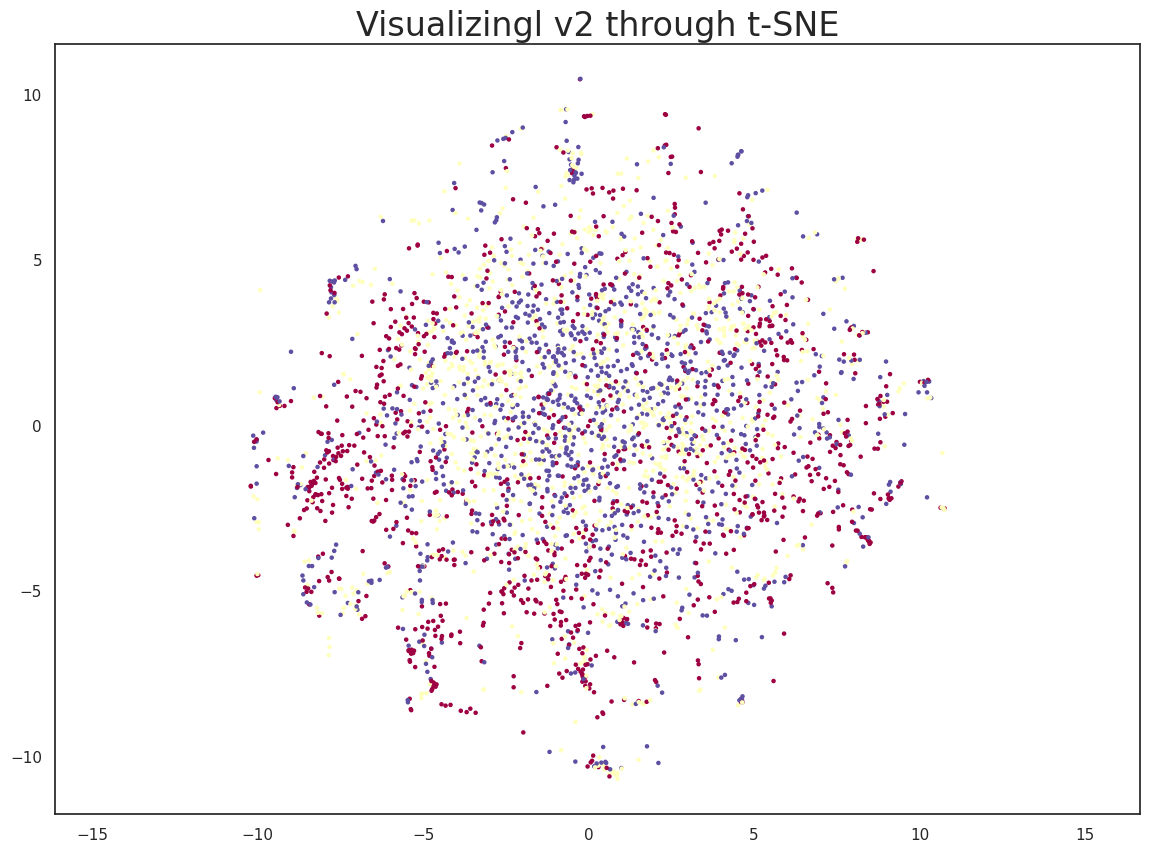

In [12]:
plt.scatter(tsne_v2[:, 0], tsne_v2[:, 1], s= 5, c=data_v2['y'], cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.title('Visualizingl v2 through t-SNE', fontsize=24);

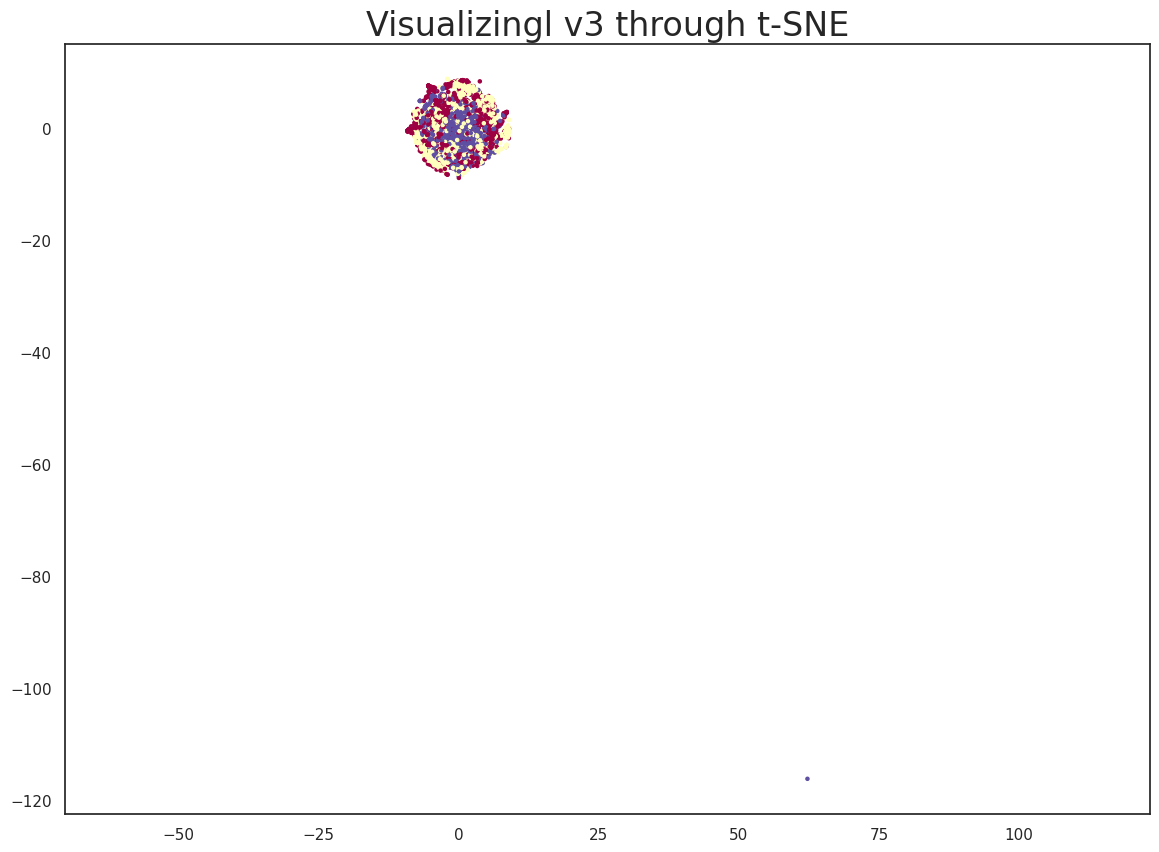

In [13]:
plt.scatter(tsne_v3[:, 0], tsne_v3[:, 1], s= 5, c=data_v3['y'], cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
# plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('Visualizingl v3 through t-SNE', fontsize=24);

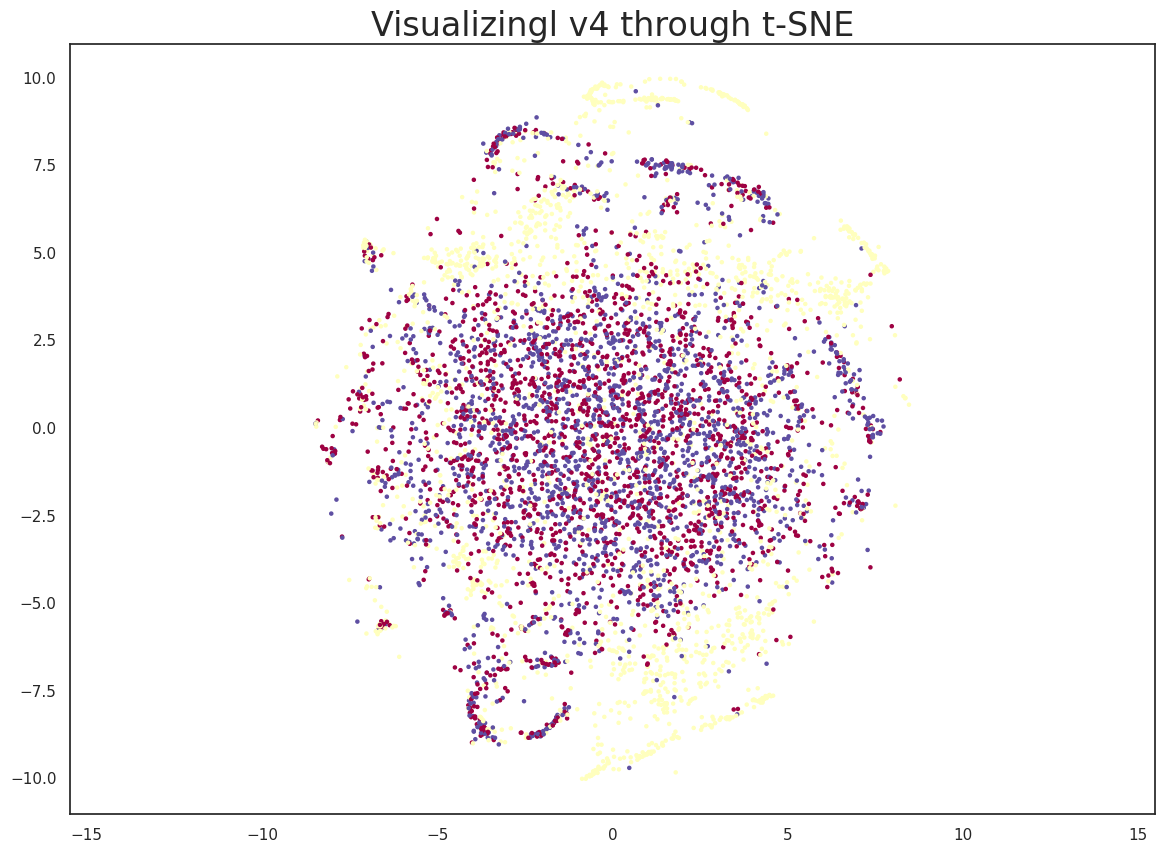

In [14]:
plt.scatter(tsne_v4[:, 0], tsne_v4[:, 1], s= 5, c=data_v4['y'], cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
# plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('Visualizingl v4 through t-SNE', fontsize=24);

## Step 4. [most important] See the data variance across sessions

In [15]:
print(x_v2.shape, x_v3.shape, x_v4.shape)
# create labels corresponding to different sessions
y_v2 = np.array([2 for i in range(x_v2.shape[0])])
y_v3 = np.array([3 for i in range(x_v3.shape[0])])
y_v4 = np.array([4 for i in range(x_v4.shape[0])])
print(y_v2.shape, y_v3.shape, y_v4.shape)

X_all = np.concatenate([x_v2, x_v3, x_v4])
y_all = np.concatenate([y_v2, y_v3, y_v4])

print(X_all.shape, y_all.shape)

(3600, 3500) (6000, 3500) (6000, 3500)
(3600,) (6000,) (6000,)
(15600, 3500) (15600,)


In [16]:
tsne_all = TSNE(random_state=42, n_components=2, verbose=0, perplexity=40, n_iter=300).fit_transform(X_all)

/home/pai/envs/fbc/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/pai/envs/fbc/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Text(0.5, 1.0, 'Visualizingl cross-session through t-SNE')

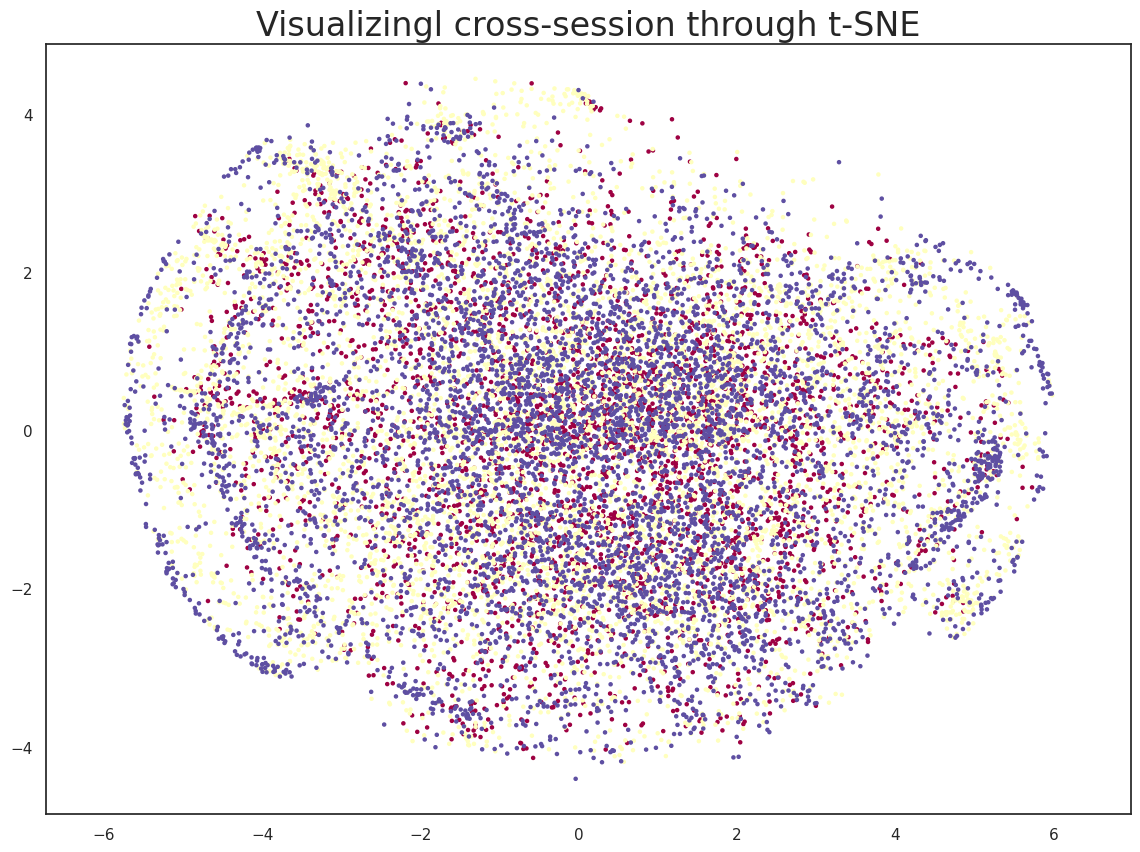

In [17]:
plt.scatter(tsne_all[:, 0], tsne_all[:, 1], s=5, c=y_all, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
# plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('Visualizingl cross-session through t-SNE', fontsize=24)

In [18]:
standardized_all = StandardScaler().fit_transform(X_all)
print(standardized_all.shape)

(15600, 3500)


In [19]:
tsne_all_stand = TSNE(random_state=42, n_components=2, verbose=0, perplexity=40, n_iter=300).fit_transform(standardized_all)

/home/pai/envs/fbc/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/pai/envs/fbc/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Text(0.5, 1.0, 'Visualizingl cross-session through t-SNE[after standardization]')

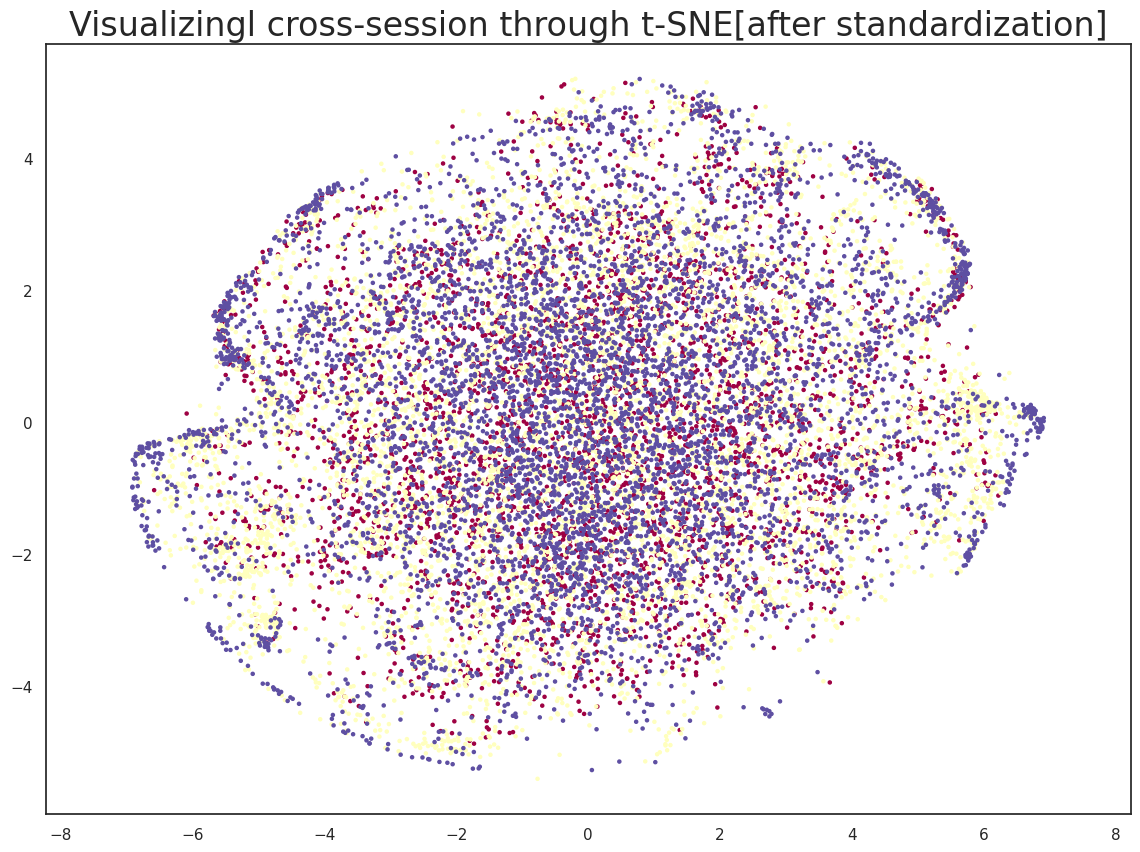

In [20]:
plt.scatter(tsne_all_stand[:, 0], tsne_all_stand[:, 1], s=5, c=y_all, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
# plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('Visualizingl cross-session through t-SNE[after standardization]', fontsize=24)

## References

- https://www.kaggle.com/code/parulpandey/visualizing-kannada-mnist-with-t-sne
